In [ ]:
!pip install vectorbt
!pip uninstall -y cffi
!pip uninstall -y _cffi_backend
!pip install cffi==1.17.0
import cffi
import _cffi_backend
print(cffi.__version__)
print(_cffi_backend.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 15.0 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Created wheel for vectorbt: filename=vectorbt-0.26.2-py3-none-any.whl size=527327 sha256=f4586dcded11b72aecd8c7f81fe15794261ca2b722fd045aa24dce9bf77d6f76
  Stored in directory: /root/.cache/pip/wheels/35/a3/d2/ae1a8cbf659fffc7d1890123df1a7fa2e7f6df587c1dca71cd
Successfully built vectorbt
  Attempting uninstall: numpy
    Found existing installation: numpy 1.

Found existing installation: cffi 1.17.1
Uninstalling cffi-1.17.1:
  Successfully uninstalled cffi-1.17.1
ERROR: Invalid requirement: '_cffi_backend': Expected package name at the start of dependency specifier
    _cffi_backend
    ^
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.9/445.9 kB 9.0 MB/s eta 0:00:00


1.17.1
1.17.0


In [ ]:
import vectorbt as vbt
# import talib as ta
import requests
import json
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import time
import datetime

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
# from pmdarima import auto_arima



In [ ]:
class GetBinanceData:
    @staticmethod
    def get_data(symbol, interval, startDate=datetime.datetime(2020, 1, 1), endDate=datetime.datetime.now()):
        dataList = []
        current_date = datetime.datetime.now()
        start_date = startDate

        delta_units = GetBinanceData.convert_to_minutes(interval)
        print(delta_units)
        delta = datetime.timedelta(minutes=delta_units)

        while start_date < current_date:
            end_date = start_date + delta
            if end_date > current_date:
                end_date = current_date
            # Convert datetime objects to milliseconds
            start_ms = int(start_date.timestamp() * 1000)
            end_ms = int(end_date.timestamp() * 1000)

            start_str = start_date.strftime('%Y-%m-%d %H:%M:%S')
            end_str = end_date.strftime('%Y-%m-%d %H:%M:%S')

            # print(f"Fetching data from {start_str} to {end_str}")
            data = GetBinanceData.get_historical_data(symbol, interval, start_ms, end_ms)
            if data:
                dataList.extend(data)
            start_date = end_date
            time.sleep(1)

        return dataList

    @staticmethod
    def get_historical_data(symbol, interval, start_time, end_time):
        url = f"https://api.binance.us/api/v3/klines"
        params = {
            'symbol': symbol.upper(),
            'interval': interval,
            'startTime': start_time,
            'endTime': end_time,
            'limit': 1000
        }
        # print(params)
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            return data
        else:

            print(f"Failed to fetch data. Status code: {response.json()}")
            return None

    @staticmethod
    def convert_to_minutes(time_str):
        time_mapping = {
            'm': 1,
            'h': 60,
            'd': 1440,
            'w': 10080,
            'M': 43200
        }

        num = int(time_str[:-1])
        unit = time_str[-1]

        return (num * time_mapping[unit])*1000

    def data_to_dataframe(data):
      # Define the column names based on Binance API response
      columns = [
          "timestamp", "open", "high", "low", "close", "volume",
          "Close Time", "Quote Asset Volume", "Number of Trades",
          "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
      ]
      # Convert the data to a pandas DataFrame
      df = pd.DataFrame(data, columns=columns)
      df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
      df['close'] = df['close'].astype(float)
      df['open'] = df['open'].astype(float)
      df['high'] = df['high'].astype(float)
      df['low'] = df['low'].astype(float)
      # df.set_index('date', inplace=True)
      # # Convert timestamp columns to datetime
      # df["timestamp"] = pd.to_datetime(df['timestamp'])
      # df["Close Time"] = pd.to_datetime(df["Close Time"], unit='ms')
      # # Convert numeric columns to float
      # numeric_columns = ["open", "high", "low", "close", "volume", "Quote Asset Volume",
      #                   "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume"]
      # df[numeric_columns] = df[numeric_columns].astype(float)
      return df

    @staticmethod
    def get_data_dataFrame(symbol, interval, startDate=datetime.datetime(2020, 1, 1), endDate=datetime.datetime.now()):
        data = GetBinanceData.get_data(symbol, interval, startDate, endDate)
        return GetBinanceData.data_to_dataframe(data)

In [ ]:
Modeldate = datetime.datetime(2022, 6, 1)
timeperiod = '1d'
eth_btc_data = GetBinanceData.get_data("ethbtc", timeperiod, startDate=Modeldate , endDate=datetime.datetime.now())
eth_usdt_data = GetBinanceData.get_data("ethusdt", timeperiod, startDate=Modeldate , endDate=datetime.datetime.now())
btc_usdt_data = GetBinanceData.get_data("btcusdt", timeperiod, startDate=Modeldate , endDate=datetime.datetime.now())
#creating DataFrame
df_eth_btc = GetBinanceData.data_to_dataframe(eth_btc_data)
df_eth_usdt= GetBinanceData.data_to_dataframe(eth_usdt_data)
df_btc_usdt= GetBinanceData.data_to_dataframe(btc_usdt_data)
df_eth_btc.rename(columns={'close': 'ethbtc'}, inplace=True)
df_eth_usdt.rename(columns={'close': 'ethusdt'}, inplace=True)
df_btc_usdt.rename(columns={'close': 'btcusdt'}, inplace=True)

# Merge the data on the timestamp
data = df_eth_btc[['date', 'ethbtc']].merge(
    df_eth_usdt[['date', 'ethusdt']], on='date'
).merge(
    df_btc_usdt[['date', 'btcusdt']], on='date'
)

# Make sure all data is sorted by time
df = data.sort_values('date').reset_index(drop=True)




NameError: name 'datetime' is not defined

In [ ]:
def rolling_predict(train, test, exog_train, exog_test, window=150):
    preds = []

    # Start predicting from the first point in the test set
    for i in range(len(test)):
        # Define the training data for this iteration
        endog_train = train['ethbtc_close'].iloc[-window:]
        exog_train_current = exog_train.iloc[-window:]

        # Fit the SARIMAX model
        model = SARIMAX(endog_train, exog=exog_train_current, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
        results = model.fit(disp=False)

        # Make the prediction
        pred = results.predict(start=len(endog_train), end=len(endog_train), exog=exog_test.iloc[i:i+1])
        preds.append(pred.values[0])  # Append the prediction to the list

    return preds, results

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

window_size = 150


predicted_values = []


for i in range(window_size, len(df)):

    train_data = df.iloc[i-window_size:i]


    model = SARIMAX(train_data['ethbtc'], exog=train_data[['btcusdt', 'ethusdt']], order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
    results = model.fit(disp=False)


    exog_next = df[['btcusdt', 'ethusdt']].iloc[i:i+1]
    prediction = results.forecast(steps=1, exog=exog_next)
    predicted_values.append(prediction.values[0])


predicted_df = pd.DataFrame(predicted_values, index=df.index[window_size:], columns=['Predicted_ETH_BTC'])





/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [ ]:
Modeldate = datetime.datetime(2023, 6, 1)
date = datetime.datetime(2020, 1, 1)
timeperiod = '1d'
eth_btc_data_Future = GetBinanceData.get_data("ethbtc", timeperiod, startDate=date , endDate=datetime.datetime.now())
eth_usdt_data_Future = GetBinanceData.get_data("ethusdt", timeperiod, startDate=date , endDate=datetime.datetime.now())
btc_usdt_data_Future = GetBinanceData.get_data("btcusdt", timeperiod, startDate=date , endDate=datetime.datetime.now())
#creating DataFrame
df_eth_btc_Future = GetBinanceData.data_to_dataframe(eth_btc_data_Future)
df_eth_usdt_Future= GetBinanceData.data_to_dataframe(eth_usdt_data_Future)
df_btc_usdt_Future= GetBinanceData.data_to_dataframe(btc_usdt_data_Future)
df_eth_btc_Future.rename(columns={'close': 'ethbtc'}, inplace=True)
df_eth_usdt_Future.rename(columns={'close': 'ethusdt'}, inplace=True)
df_btc_usdt_Future.rename(columns={'close': 'btcusdt'}, inplace=True)

# Merge the data on the timestamp
data_Future = df_eth_btc_Future[['date', 'ethbtc']].merge(
    df_eth_usdt[['date', 'ethusdt']], on='date'
).merge(
    df_btc_usdt_Future[['date', 'btcusdt']], on='date'
)

# Make sure all data is sorted by time
df_Future = data_Future.sort_values('date').reset_index(drop=True)

len(df)



1440000
1440000
1440000


490

In [ ]:

future_predictions = []

for index, row in df_Future.iterrows():

    exog_next = pd.DataFrame([[row['btcusdt'], row['ethusdt']]], columns=['btcusdt', 'ethusdt'])


    prediction = results.forecast(steps=1, exog=exog_next)
    future_predictions.append(prediction.values[0])

# Create a DataFrame for the test predictions
df_Future['Predicted_ETH_BTC'] = future_predictions

# Display the results
print(df_Future)

          date    ethbtc  ethusdt   btcusdt  Predicted_ETH_BTC
0   2023-06-01  0.069382  1861.82  26815.41           0.055225
1   2023-06-02  0.069927  1906.44  27241.48           0.055604
2   2023-06-03  0.069832  1891.74  27068.35           0.055502
3   2023-06-04  0.069708  1890.16  27124.27           0.055439
4   2023-06-05  0.070298  1810.45  25725.97           0.055205
..         ...       ...      ...       ...                ...
485 2024-09-28  0.040740  2675.60  65908.11           0.040358
486 2024-09-29  0.040320  2657.77  65670.63           0.040253
487 2024-09-30  0.040980  2602.58  63291.96           0.041072
488 2024-10-01  0.040400  2453.73  60999.49           0.040414
489 2024-10-02  0.040150  2472.85  61550.90           0.040320

[490 rows x 5 columns]


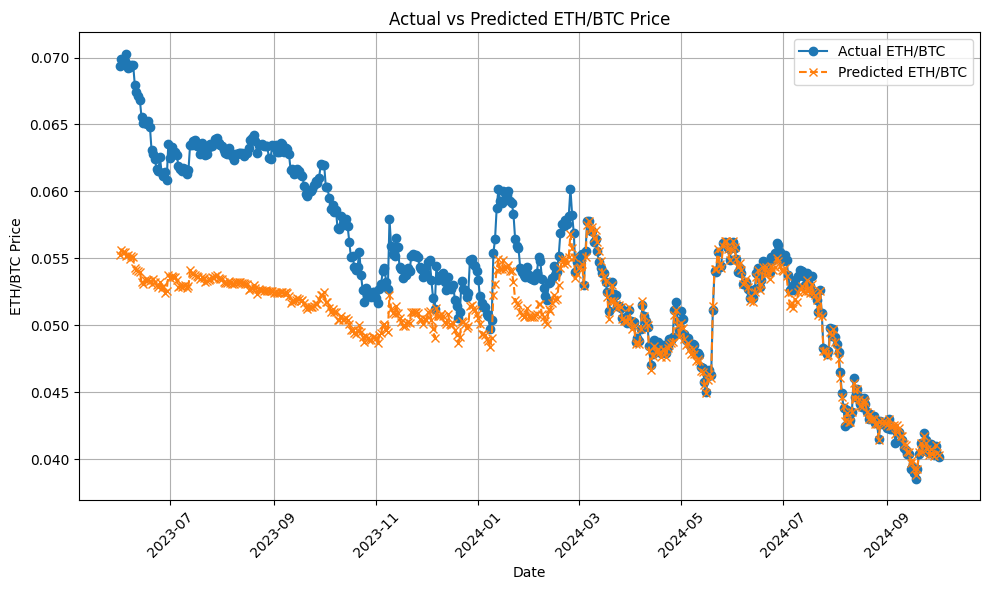

In [ ]:
# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df_Future['date'], df_Future['ethbtc'], label='Actual ETH/BTC', marker='o')
plt.plot(df_Future['date'], df_Future['Predicted_ETH_BTC'], label='Predicted ETH/BTC', marker='x', linestyle='--')

plt.xlabel('Date')
plt.ylabel('ETH/BTC Price')
plt.title('Actual vs Predicted ETH/BTC Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

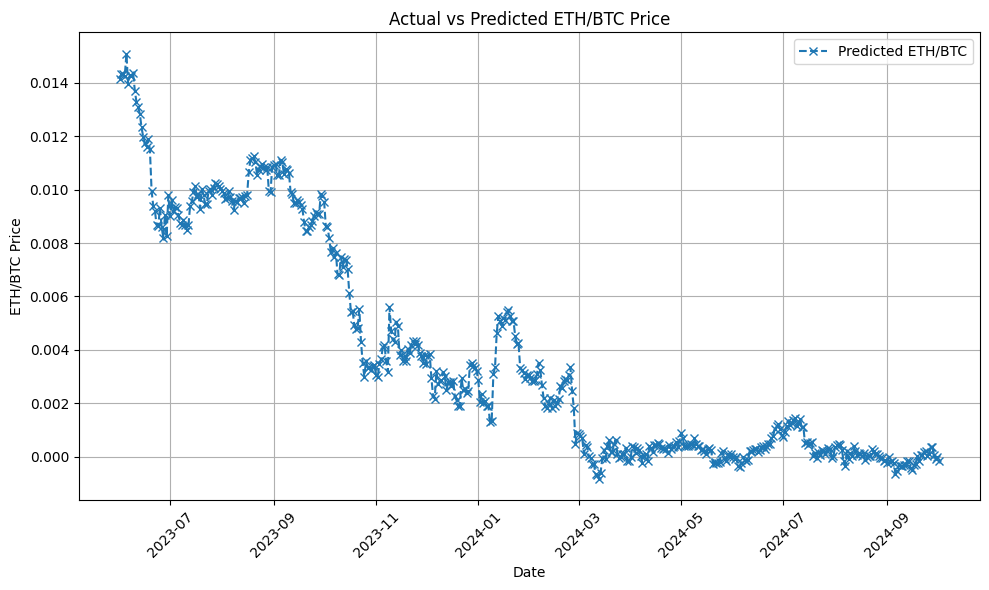

In [ ]:

df_Future['Prediction_Error'] = df_Future['ethbtc'] - df_Future['Predicted_ETH_BTC']

df_Future[['date', 'ethbtc', 'Predicted_ETH_BTC', 'Prediction_Error']]
# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# plt.plot(df_Future['date'], df_Future['ethbtc'], label='Actual ETH/BTC', marker='o')
plt.plot(df_Future['date'], df_Future['Prediction_Error'], label='Predicted ETH/BTC', marker='x', linestyle='--')

plt.xlabel('Date')
plt.ylabel('ETH/BTC Price')
plt.title('Actual vs Predicted ETH/BTC Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
#  date    ethbtc  ethusdt   btcusdt  Predicted_ETH_BTC
buy_signal = df_Future["ethbtc"] < df_Future["Predicted_ETH_BTC"]

In [ ]:
pf = vbt.Portfolio.from_signals(
    close=df_Future['ethbtc'],
    entries=buy_signal,

    tp_stop=0.05,
    init_cash=10000,
    freq=timeperiod,
    sl_stop=0.1,
    sl_trail=True,

)

# Performance metrics
print(pf.stats())

# Plot the results
pf.plot().show()

Start                                         0
End                                         489
Period                        490 days 00:00:00
Start Value                             10000.0
End Value                           6737.628337
Total Return [%]                     -32.623717
Benchmark Return [%]                 -42.131965
Max Gross Exposure [%]                    100.0
Total Fees Paid                             0.0
Max Drawdown [%]                      36.819606
Max Drawdown Duration         207 days 00:00:00
Total Trades                                  9
Total Closed Trades                           8
Total Open Trades                             1
Open Trade PnL                      -139.283475
Win Rate [%]                               37.5
Best Trade [%]                         8.523664
Worst Trade [%]                      -11.059281
Avg Winning Trade [%]                  6.822683
Avg Losing Trade [%]                 -10.813413
Avg Winning Trade Duration      4 days 0